In [2]:
import numpy as np
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load The FER dataset

In [12]:
img_shape = (48, 48)
images = pd.read_csv('../data/fer/fer2013.csv')

In [13]:
labels_map = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

### Parse the data: *A string of pixels to 2d array*

In [28]:
def parse_pixelstr(pixelstr, shape=img_shape):
    return np.array(list(map(int, pixelstr.split(' ')))).reshape(shape)

In [29]:
image = parse_pixelstr(images['pixels'][0])

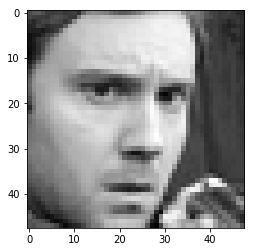

In [30]:
plt.imshow(image, cmap='gray');

## Train/Test/Dev split

In [34]:
images['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [35]:
X_train, X_test, X_dev = [], [], []
y_train, y_test, y_dev = [], [], []

In [37]:
for idx, row in images.iterrows():
    if row['Usage'] == 'Training':
        X_train.append(parse_pixelstr(row['pixels']))
        y_train.append(row['emotion'])
        
    elif row['Usage'] == 'PublicTest':
        X_test.append(parse_pixelstr(row['pixels']))
        y_test.append(row['emotion'])
        
    else: # Private Test set or Dev set
        X_dev.append(parse_pixelstr(row['pixels']))
        y_dev.append(row['emotion'])